In [1]:
from sklearn.datasets import make_circles, make_moons
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split
from cvxopt import matrix
from cvxopt import solvers
from numpy import linalg as LA

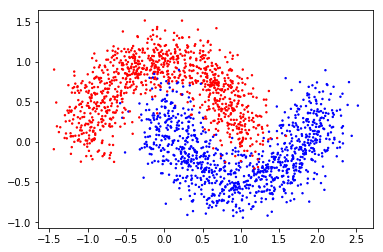

In [2]:
X, y = make_moons(n_samples=2000, noise=0.2)
colors = ['red','blue']
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=matplotlib.colors.ListedColormap(colors), s=2)
y[y == 0] = -1
seed = 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

## MCMC sampling method

In [3]:
def metropolis_hastings(p, dim, iter=1000):
    x = np.zeros(dim)
    samples = np.zeros((iter, dim))

    for i in range(iter):
        x_next = x + np.random.multivariate_normal(np.zeros(dim), np.eye(dim))
        if np.random.rand() < p(x_next) / p(x):
            x = x_next
        samples[i] = x

    return samples

In [4]:
def p(delta):
    if delta < 0.:
        return 0.
    else:
        return delta * np.exp(-delta)

In [5]:
def one_hot(dim, pos):
    vec = np.zeros(int(dim))
    vec[int(pos)] = 1.
    return vec

In [6]:
spans = np.zeros(X_train.shape[-1])
for i in range(X_train.shape[-1]):
    spans[i] = np.max(X_train[:, i]) - np.min(X_train[:, i])

In [7]:
max_iter = 1000
P = 30
d = 2
deltas = np.zeros((P, d))
us = np.zeros((P, d))
num_of_bins_collect = []

# draw grid parameters
for i in range(P):
    s = metropolis_hastings(p, 1, iter=max_iter)
    delta = s[np.random.randint(low=20, high=max_iter, size=d)]
    u =  np.random.uniform(low=0, high=delta)
    delta = delta.reshape(delta.shape[0])
    u = u.reshape(u.shape[0])
    deltas[i, :] = delta
    us[i, :] = u
    num_of_bins = (np.ceil((spans) / delta)).astype("int") + 1
    num_of_bins_collect.append(num_of_bins)

X_train_map = []
lower = np.min(X_train, axis=0)

for i in range(X_train.shape[0]):
    x = X_train[i]
    X_map = []
    
    for j in range(P):
        bin_idx = (np.ceil((x - lower - us[j, :]) / deltas[j, :])).astype("int")
        X_map.append(np.array([one_hot(dim, pos) for dim, pos in zip(num_of_bins_collect[j], bin_idx)]))
        
    X_train_map.append(X_map)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


In [8]:
def cross_product(x1, x2):
    s = 0
    for i in range(len(x1)):
        for j in range(x1[i].shape[0]):
            s += np.dot(x1[i][j], x2[i][j])
    return s

In [9]:
taille = len(X_train_map)
K = np.zeros((taille, taille))
for i in range(taille):
    for j in range(taille):
        K[i, j] = cross_product(X_train_map[i], X_train_map[j])

In [10]:
K

array([[60., 32., 33., ..., 29., 22., 20.],
       [32., 60., 25., ..., 40., 30., 32.],
       [33., 25., 60., ..., 39., 36., 17.],
       ...,
       [29., 40., 39., ..., 60., 37., 24.],
       [22., 30., 36., ..., 37., 60., 37.],
       [20., 32., 17., ..., 24., 37., 60.]])

## bin density in each direction

In [11]:
m = K.shape[0]
y_train = y_train.reshape(-1,1) * 1.
H = np.outer(y_train, y_train) * K
H.shape

C = 10
P = matrix(H)
q = matrix(-np.ones(m))
G = matrix(np.vstack((np.eye(m)*-1,np.eye(m))))
h = matrix(np.hstack((np.zeros(m), np.ones(m) * C)))
A = matrix(y_train, (1, m))
b = matrix(0.)

#Run solver
sol = solvers.qp(P, q, G, h, A, b)
alphas = np.array(sol['x'])

alphas = alphas.reshape(alphas.shape[0])

sup_vec_idx = np.argwhere(np.logical_or(alphas > 1e-4, alphas < -1e-4))
sup_vec_idx = sup_vec_idx.reshape(sup_vec_idx.shape[0])
X_sup_vec = X_train[sup_vec_idx]
y_sup_vec = y_train[sup_vec_idx]
alphas_sup_vec = alphas[sup_vec_idx]

     pcost       dcost       gap    pres   dres
 0: -1.5854e+03 -1.2622e+05  4e+05  1e+00  2e-12
 1: -9.0659e+02 -4.6893e+04  8e+04  2e-01  2e-12
 2: -4.7168e+02 -1.1311e+04  2e+04  3e-02  1e-12
 3: -4.2953e+02 -3.9312e+03  5e+03  8e-03  1e-12
 4: -5.2464e+02 -1.9872e+03  2e+03  3e-03  1e-12
 5: -6.0641e+02 -1.3290e+03  8e+02  1e-03  1e-12
 6: -6.5725e+02 -1.0621e+03  4e+02  4e-04  1e-12
 7: -6.7537e+02 -9.6725e+02  3e+02  1e-04  1e-12
 8: -6.9884e+02 -8.8484e+02  2e+02  6e-05  1e-12
 9: -7.1390e+02 -8.3567e+02  1e+02  1e-05  1e-12
10: -7.3016e+02 -7.9501e+02  7e+01  6e-06  1e-12
11: -7.3609e+02 -7.7411e+02  4e+01  1e-14  1e-12
12: -7.4456e+02 -7.5774e+02  1e+01  2e-16  1e-12
13: -7.4654e+02 -7.5395e+02  7e+00  2e-14  1e-12
14: -7.4766e+02 -7.5224e+02  5e+00  3e-14  1e-12
15: -7.4922e+02 -7.5006e+02  8e-01  6e-14  1e-12
16: -7.4956e+02 -7.4960e+02  5e-02  6e-14  1e-12
17: -7.4958e+02 -7.4958e+02  7e-04  2e-16  1e-12
Optimal solution found.


In [12]:
sup_vec_idx.shape

(196,)

## transform test data

In [35]:
max_iter = 1000
P = 30
d = 2

X_test_map = []
lower = np.min(X_test, axis=0)

for i in range(X_test.shape[0]):
    x = X_test[i]
    X_map = []
    
    for j in range(P):
        bin_idx = (np.ceil((x - lower - us[j, :]) / deltas[j, :])).astype("int")
        X_map.append(np.array([one_hot(dim, pos) for dim, pos in zip(num_of_bins_collect[j], bin_idx)]))
        
    X_test_map.append(X_map)

In [36]:
X_sup_vec.shape

(196, 2)

In [37]:
len(X_train_map)

1600

In [38]:
y_train.shape

(1600, 1)

In [39]:
(X_train_map[4][1][0]).shape

(2,)

In [40]:
X_train_map[4][1] + X_train_map[4][1]

array([array([2., 0.]),
       array([0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.])],
      dtype=object)

In [41]:
weights = []
for i in range(P):
    temp = []
    for j in range(len(X_train_map[0][i])):
        temp.append(np.zeros(X_train_map[0][i][j].shape))
    weights.append(np.array(temp))

In [42]:
for idx in sup_vec_idx:
    w_temp = []
    for j in range(P):
        weights[j] += X_train_map[idx][j] * y_train[idx] * alphas[idx]

In [43]:
len(weights)

30

In [44]:
cross_product(X_train_map[10], weights)

2.1588562355352496

In [45]:
pred = []
for x in X_test_map:
    pred.append(np.sign(cross_product(x, weights)))
pred = np.array(pred)

In [46]:
np.sum((pred == y_test).astype("int")) / y_test.shape[0]

0.955